In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import glob
from matplotlib.ticker import FixedLocator, FixedFormatter

from libraries import Libraries

In [2]:
frac = 1 # what fraction of data to work at. 1 for 100 data, .8 for 80, .6 for 60, .4 for 40, .2 for 20, .1 for 10 data
deg = 5
deg_trigo = 4
np.random.seed(145)

In [3]:
path = r'data/ellipsoid_inclined_data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    frame = pd.read_csv(filename, index_col=None, header=0)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df = pd.DataFrame(df, columns= ['Re', 'phi', 'theta', 'Exp C_d'])

shuffled_df = df.sample(frac=frac)

data = shuffled_df.to_numpy()
Re = data[:,0]
phi = data[:,1]
theta = data[:,2]
Cd = data[:,3]
inp = data[:,0:3]


In [4]:

inp_train, inp_test, Cd_train, Cd_test = train_test_split(inp, Cd, test_size=0.1, shuffle=True)
Re_train = inp_train[:,0]
phi_train = inp_train[:,1]
theta_train = inp_train[:,2]
Re_test = inp_test[:,0]
phi_test = inp_test[:,1]
theta_test = inp_test[:,2]


In [5]:
mode_list = ['phim1', 'basic', 'basicphim1']
alphas = np.linspace(1e2, 1e5, 10) 
results = {mode: {} for mode in mode_list}
verbose = True

for i in range(len(mode_list)):
    mode = mode_list[i]
    L = Libraries(mode, deg, deg_trigo)
    library_train, library_names = L.library(Re_train, phi_train, theta_train)
    library_test, library_names = L.library(Re_test, phi_test, theta_test)

    reg = linear_model.LassoCV(fit_intercept=False, alphas=alphas, positive=True, tol=1e-3, max_iter=1000000)
    reg.fit(library_train, Cd_train)

    Cd_pred = reg.predict(library_test)
    train_score = reg.score(library_train, Cd_train)
    test_score = reg.score(library_test, Cd_test)

    rmse_train = np.sqrt(mean_squared_error(Cd_train, reg.predict(library_train)))
    rmse_test = np.sqrt(mean_squared_error(Cd_test, reg.predict(library_test)))

    coefs = reg.coef_
    learned_dict = list(zip(library_names, coefs))

    learned_coefs = []
    learned_libs = []
    for i in range(len(learned_dict)):
        if np.abs(learned_dict[i][1]) > 0:
            learned_coefs.append(learned_dict[i][1])
            learned_libs.append(learned_dict[i][0])

    results[mode]['losses'] = [rmse_train, rmse_test, train_score, test_score]
    results[mode]['learned_coefs'] = learned_coefs
    results[mode]['learned_libs'] = learned_libs
    results[mode]['library_names'] = library_names
    results[mode]['reg'] = reg

    
    if verbose:
        print('\nMODE: ', mode)

        print('alpha = ', reg.alpha_)
        print("train score: ",train_score)
        print("test score: ",test_score)

        print("RMSE train: ",rmse_train)
        print("RMSE test: ",rmse_test)
        print("----")

        for i in range(len(learned_dict)):
            if np.abs(learned_dict[i][1]) > 0:
                print(f'{learned_dict[i][1]:.4f} \t {learned_dict[i][0]}')

        print("=============")


MODE:  phim1
alpha =  100.0
train score:  0.9986448475061145
test score:  0.997390594480599
RMSE train:  149.1052434065568
RMSE test:  248.78631049096884
----
14.3818 	 Re^-1phi^-1
11.4447 	 Re^-1phi^0
0.7840 	 Re^-1 (phi-1)^1 theta^2
0.0384 	 Re^-1 (phi-1)^1 theta^4

MODE:  basic
alpha =  100.0
train score:  0.9989372282524444
test score:  0.9993047920937156
RMSE train:  132.04404869463613
RMSE test:  128.41419761592212
----
0.0000 	 Re^-4 phi^0 theta^0
0.0000 	 Re^-3 phi^0 theta^0
0.0000 	 Re^-2 phi^0 theta^0
16.6946 	 Re^-1 phi^-1 theta^0
0.0009 	 Re^-1 phi^-1 theta^4
8.6094 	 Re^-1 phi^0 theta^0
0.8058 	 Re^-1 phi^0 theta^1
0.2343 	 Re^-1 phi^0 theta^2
0.4819 	 Re^-1 phi^1 theta^0
0.4135 	 Re^-1 phi^1 theta^1
0.0040 	 Re^-1 phi^1 theta^2

MODE:  basicphim1
alpha =  100.0
train score:  0.9990461237934751
test score:  0.9994418196623149
RMSE train:  125.09640801351263
RMSE test:  115.0649248748825
----
0.0000 	 Re^-2 (phi-1)^0 theta^1
0.0001 	 Re^-2 (phi-1)^0 theta^2
4.4555 	 Re^-1 

In [6]:
# Plot results and compare with data
# Start with Re=0.1 and phi = 6

Re_list = np.sort(np.unique(Re))
phi_list = np.sort(np.unique(phi))

Re0 = Re_list[-1] 
phi0 = phi_list[-1] 

print('Re = ', Re0, '; phi = ', phi0)

datafilt = shuffled_df[(shuffled_df['Re'] == Re0) & (shuffled_df['phi'] == phi0)]
theta_list = np.array(datafilt['theta'])
Cd_list = np.array(datafilt['Exp C_d'])

idxsort = np.argsort(theta_list)
theta_sorted0 = theta_list[idxsort]
Cd_sorted0 = Cd_list[idxsort]


Re =  0.1 ; phi =  6.0


/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:23: RuntimeWarning: invalid value encountered in reciprocal
  lib1[:,counter] = Re**i * phi**j
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:31: RuntimeWarning: invalid value encountered in reciprocal
  lib2[:,counter] = Re**k * (phi-1)**i * theta**(j)
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:48: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:61: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * (phi-1)**j * theta**k


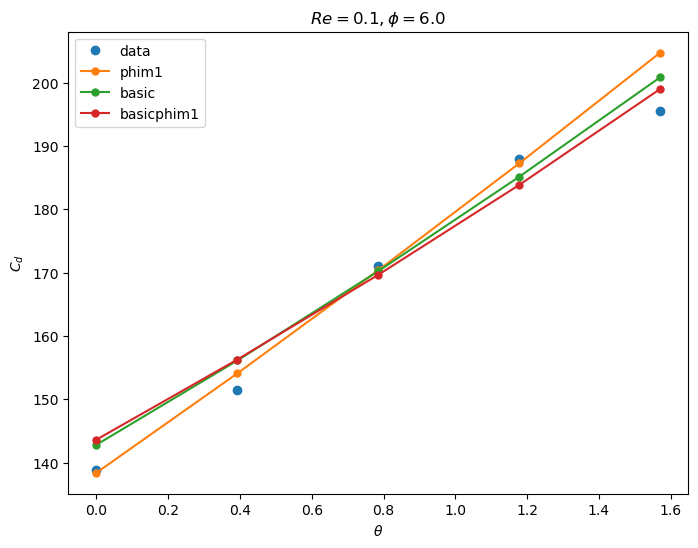

In [7]:
# Plot

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(theta_sorted0, Cd_sorted0, 'o', label='data')

for mode in mode_list:
    L = Libraries(mode, deg, deg_trigo)
    lib, lib_names = L.library(np.array(datafilt['Re']), np.array(datafilt['phi'], dtype=float), theta_sorted0)
    Cd_pred0 = results[mode]['reg'].predict(lib)
    ax.plot(theta_sorted0, Cd_pred0, '.-', ms=10, label=mode)


ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$C_d$')
ax.set_title(f'$Re = {Re0}, \phi = {phi0}$')
ax.legend()
plt.show()


In [8]:
# List of Re and phi values in data

# theta = {}

# XRe, Yphi = np.meshgrid(Re_list, phi_list)

# Z = np.zeros((len(theta_list), len(Re_list)))
# for i in range(len(Re_list)):
#     for j in range(len(phi_list)):
#         thetas[(i, j)] = shuffled_df['theta'][shuffled_df['Re'] == Re_list[i]][shuffled_df['phi'] == phi_list[j]]



/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:23: RuntimeWarning: invalid value encountered in reciprocal
  lib1[:,counter] = Re**i * phi**j
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:31: RuntimeWarning: invalid value encountered in reciprocal
  lib2[:,counter] = Re**k * (phi-1)**i * theta**(j)
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:48: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:61: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * (phi-1)**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:23: RuntimeWarning: invalid value encountered in reciprocal
  lib1[:,counter] = Re**i * phi**j
/Users/josephbakarji/Documents/academic

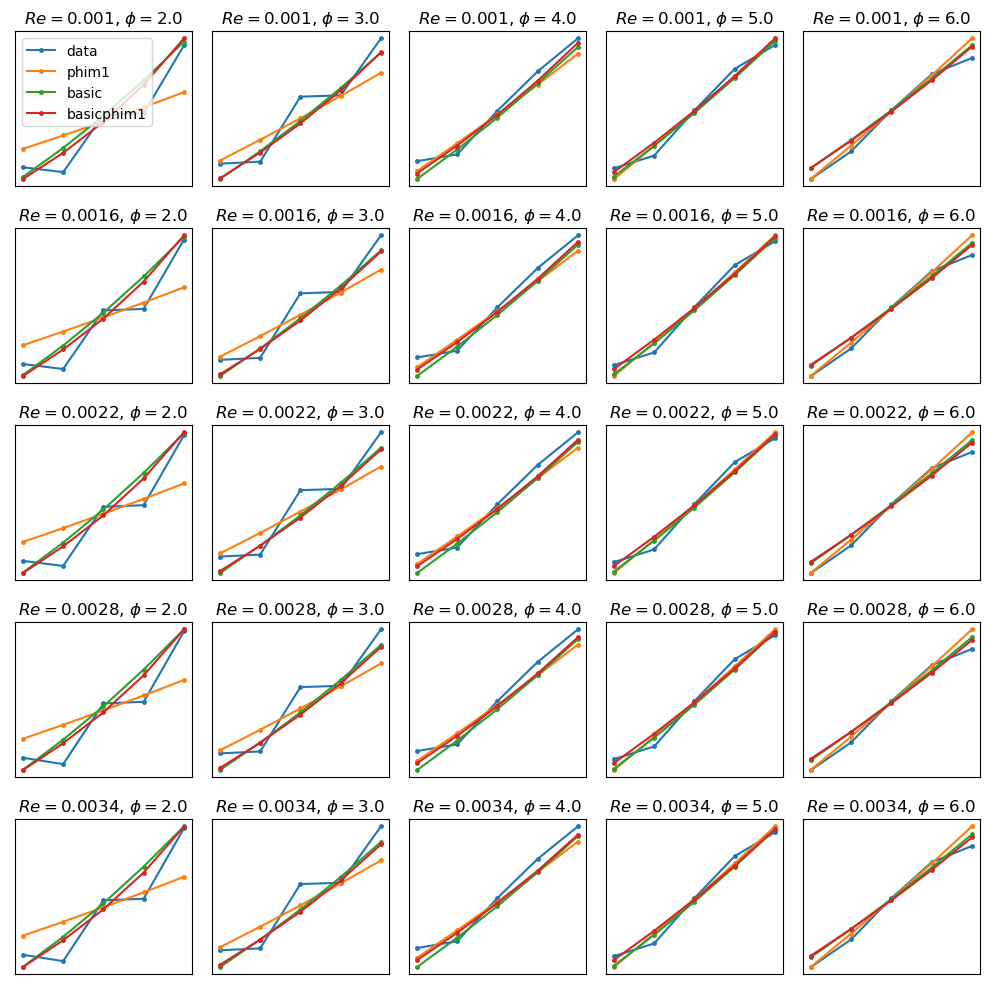

In [9]:
# Grid of subplots for first 5 values of Re and phi

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        Re0 = Re_list[i] 
        phi0 = phi_list[j] 

        datafilt = shuffled_df[(shuffled_df['Re'] == Re0) & (shuffled_df['phi'] == phi0)]
        theta_list = np.array(datafilt['theta'])
        Cd_list = np.array(datafilt['Exp C_d'])

        idxsort = np.argsort(theta_list)
        theta_sorted = theta_list[idxsort]
        Cd_sorted = Cd_list[idxsort]

        ax[i, j].plot(theta_sorted, Cd_sorted, '.-', ms=5, label='data')

        for mode in mode_list:
            L = Libraries(mode, deg, deg_trigo)
            lib, lib_names = L.library(np.array(datafilt['Re']), np.array(datafilt['phi'], dtype=float), theta_sorted)
            Cd_pred = results[mode]['reg'].predict(lib)
            ax[i, j].plot(theta_sorted, Cd_pred, '.-', ms=5, label=mode)

        # ax[i, j].set_xlabel(r'$\theta$')
        # ax[i, j].set_ylabel(r'$C_d$')
        ax[i, j].set_title(r'$Re = $'+str(Re0)+r', $\phi = $'+str(phi0))
        # remove xticks
        ax[i, j].xaxis.set_major_locator(FixedLocator([]))
        ax[i, j].xaxis.set_major_formatter(FixedFormatter([]))
        ax[i, j].yaxis.set_major_locator(FixedLocator([]))
        ax[i, j].yaxis.set_major_formatter(FixedFormatter([]))

ax[0, 0].legend()

plt.tight_layout()

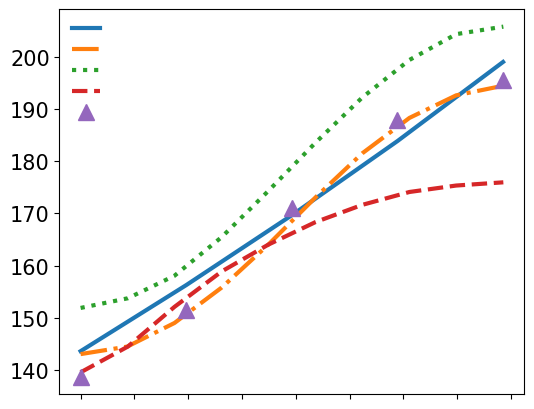

In [10]:
ouchene = [[0, 151.91780821917806],
[10.056497175141246, 153.7671232876712],
[20.000000000000004, 158.0821917808219],
[30.05649717514125, 165.47945205479448],
[40, 174.31506849315065],
[50.05649717514126, 183.56164383561642],
[60.000000000000014, 192.19178082191777],
[70.05649717514125, 199.3835616438356],
[80, 204.31506849315065],
[90.05649717514125, 205.75342465753423]]

theoretical = [[0, 143.0821917808219],
[9.943502824858761, 144.52054794520546],
[20.000000000000004, 149.04109589041093],
[30.05649717514125, 155.82191780821915],
[40, 164.04109589041093],
[50.05649717514126, 173.0821917808219],
[60.000000000000014, 181.50684931506845],
[70.05649717514125, 188.28767123287668],
[80, 192.60273972602738],
[90.05649717514125, 194.4520547945205]]

hns = [[0, 139.5890410958904],
[10.056497175141246, 144.52054794520546],
[20.000000000000004, 152.12328767123284],
[30.05649717514125, 158.90410958904107],
[40, 164.04109589041093],
[50.05649717514126, 168.35616438356163],
[60.000000000000014, 171.64383561643834],
[70.05649717514125, 174.10958904109586],
[80, 175.34246575342462],
[90.05649717514125, 175.958904109589]]



ouchene = np.array(ouchene)
ouchene[:,0] = np.deg2rad(ouchene[:,0])
theoretical = np.array(theoretical)
theoretical[:,0] = np.deg2rad(theoretical[:,0])
hns = np.array(hns)
hns[:,0] = np.deg2rad(hns[:,0])

# ax.plot(theta_sorted0, Cd_pred0, '-', lw=3, label='Learned')
# ax.plot(theoretical[: ,0], theoretical[:, 1], '-.', lw=3,label='Brenner')
# ax.plot(ouchene[:, 0], ouchene[:, 1], ':', lw=3,label='Ouchene')
# ax.plot(hns[:, 0], hns[:, 1], '--', lw=3,label='HNS')
# ax.plot(theta_sorted0, Cd_sorted0, '^', ms=12, label='Data')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(theta_sorted0, Cd_pred0, '-', lw=3, label=' ')
ax.plot(theoretical[: ,0], theoretical[:, 1], '-.', lw=3,label=' ')
ax.plot(ouchene[:, 0], ouchene[:, 1], ':', lw=3,label=' ')
ax.plot(hns[:, 0], hns[:, 1], '--', lw=3,label=' ')
ax.plot(theta_sorted0, Cd_sorted0, '^', ms=12, label=' ')
# ax.set_xlabel(r'$\phi$')
# ax.set_ylabel(r'$C_d$', fontsize=36)
# ax.yaxis.set_major_locator(FixedLocator([]))
# ax.yaxis.set_major_formatter(FixedFormatter([]))
# ax.xaxis.set_major_locator(FixedLocator([]))
ax.xaxis.set_major_formatter(FixedFormatter([]))

# set yaxis number to font 36
ax.tick_params(axis='y', labelsize=15)

# ax.set_title(r'$Re = 0.1$')
ax.legend()
#remove legend box
ax.get_legend().get_frame().set_linewidth(0.0)
plt.show()

fig.savefig('comparison.pdf')
